<a href="https://colab.research.google.com/github/itssofiarce/AAII-TUIA-Alomar-Arce/blob/main/AAII_TUIA_Alomar_Arceipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación del entorno

In [ ]:
!pip install -q gdown

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import gdown
import os.path as osp
import zipfile

# TP1-1-student_performance.zip
DATA_TP1_1='https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'
# TP1-2-diabetes.zip
DATA_TP1_2='https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_'
# TP1-3-natural-scenes.zip
DATA_TP1_3='https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'

count=0
while count != 3:
  data = [DATA_TP1_1, DATA_TP1_2, DATA_TP1_3][count]
  # Descargo
  var = gdown.download(data)
  # Extraigo
  with zipfile.ZipFile(f'{var}', 'r') as zip_ref:
    zip_ref.extractall(f'./TP1-{count+1}')

  # Variable que almacena el path de los datasets extraídos
  globals()[f"DATA_DIRECTORY_TP1_{count+1}"] = osp.abspath(f'TP1-{count+1}')

  count += 1


Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 40.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 17.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=7c0d3cfc-d0f2-4787-927b-ad0c60d6d5fb
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:02<00:00, 174MB/s] 


Establecer gpu por defecto:


In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Problema 3

Construir modelos de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar las imágenes en las siguientes categorías:
- *buildings*
- *forest*
- *glacier*
- *mountain*
- *sea*
- *street*

Arquitectura de los modelos:

- Modelo con **capas densas**
- Modelo con **capas convolucionales**
- Modelo que  inlcuya **bloques residuales de identidad**
- Modelo que utilice como *backbone* alguna de las arquitecturas disponibles en TensorFlow (*transfer learning*)


In [ ]:
# Tamaño del lote (batch size)
BATCH_SIZE = 14000
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


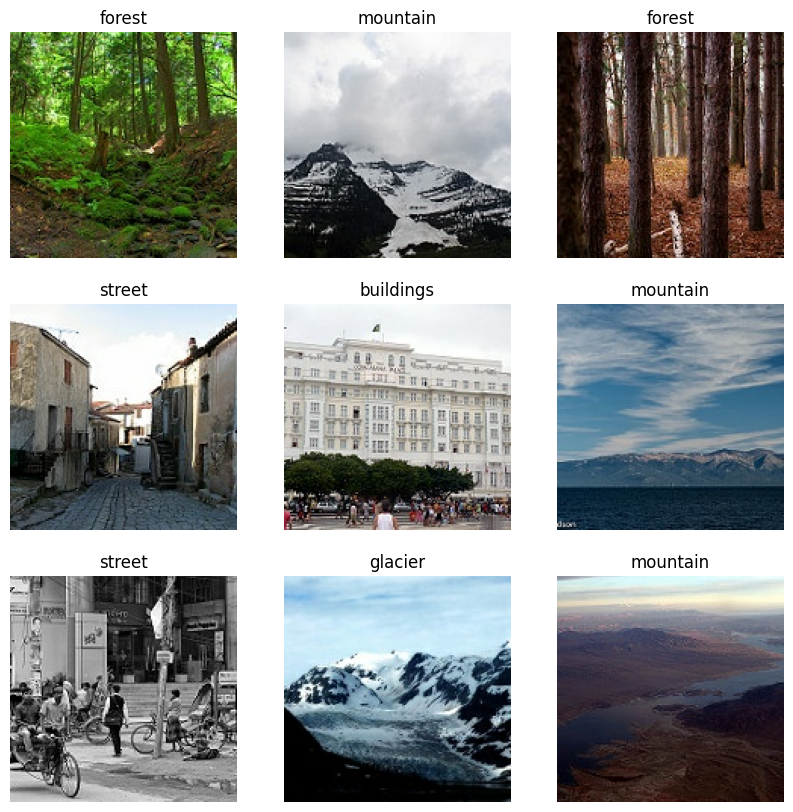

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Preprocesamiento del dataset


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Muestro una foto con los valores de sus pixeles
plt.figure()
for images, labels in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
plt.colorbar()
plt.grid(False)
plt.show()

# Modelo convolucional de capas densas

 Definimos su arquitectura


In [ ]:
num_classes = len(class_names)

# Definición del modelo usando Sequential
model = models.Sequential([
    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),

    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Capa convolucional 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar la salida para las capas densas
    layers.Flatten(),

    # Capa densa 1
    layers.Dense(128, activation='relu'),

    # Capa de salida
    layers.Dense(6, activation='softmax')  # 6 categorías
])

Compilamos el modelo

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Observamos sus métricas

In [ ]:
model.summary()

Entrenamos el modelo

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=EPOCHS,
#    batch_size=BATCH_SIZE
#)

# Modelo de capas convolucionales


# Modelo de capas convolucionales y densas


# Modelo con bloques residuales identidad
